# Сравнение ResNet50 и MobileNetV3
## Задача бинарной классификации Cats vs Dogs

**Датасет:** Microsoft Cats vs Dogs (Kaggle)



## Установка зависимостей

In [30]:
!pip install -q kaggle split-folders tensorflow matplotlib scikit-learn

## Настройка Kaggle API через переменные окружения

In [31]:
import os

os.environ['KAGGLE_USERNAME'] = "maksimdyakonov"  
os.environ['KAGGLE_KEY'] = "" # information was deleted due to security reasons, you can connect your own Kaggle account

## Загрузка и распаковка датасета

In [32]:
if not os.path.exists("data/raw/PetImages"):
    !kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset --unzip
    !mkdir -p data/raw
    !mv PetImages data/raw/

In [33]:
from PIL import Image
import os

def fully_clean_cats_vs_dogs(folder):
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
    fixed = 0
    removed = 0

    for root, _, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)

            if not file.lower().endswith(valid_extensions):
                os.remove(path)
                removed += 1
                continue

            try:
                with Image.open(path) as img:
                    rgb_img = img.convert("RGB")
                    rgb_img.save(path, format="JPEG")
                    fixed += 1
            except Exception:
                os.remove(path)
                removed += 1

    return fixed, removed

fixed, removed = fully_clean_cats_vs_dogs("data/raw/PetImages")
print(f"Исправлено изображений: {fixed}")
print(f"Удалено некорректных файлов: {removed}")


Исправлено изображений: 24998
Удалено некорректных файлов: 0


In [42]:
!ls

 data  'MSR-LA - 3467.docx'  'readme[1].txt'   sample_data


In [44]:
import os
import tensorflow as tf

def clean_dataset(folder):
    num_skipped = 0
    for folder_name in ("Cat", "Dog"):
        folder_path = os.path.join(folder, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)

    print(f"Удалено поврежденных изображений: {num_skipped}")

data_path = "data/raw/PetImages"

if os.path.exists(data_path):
    clean_dataset(data_path)
else:
    print(f"Ошибка: Путь {data_path} не найден! Проверьте содержимое командой !ls")

Удалено поврежденных изображений: 0


In [51]:
from PIL import Image
import os

def fully_clean_cats_vs_dogs(folder):
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
    fixed = 0
    removed = 0

    for root, _, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)

            if not file.lower().endswith(valid_extensions):
                os.remove(path)
                removed += 1
                continue

            try:
                with Image.open(path) as img:
                    # Explicitly check for 2-channel images (e.g., 'LA' mode)
                    if img.mode == 'LA' or len(img.getbands()) == 2:
                        os.remove(path)
                        removed += 1
                        continue

                    rgb_img = img.convert("RGB")
                    rgb_img.save(path, format="JPEG")
                    fixed += 1
            except Exception:
                os.remove(path)
                removed += 1

    return fixed, removed

fixed, removed = fully_clean_cats_vs_dogs("data/raw/PetImages")
print(f"Исправлено изображений: {fixed}")
print(f"Удалено некорректных файлов: {removed}")

Исправлено изображений: 24998
Удалено некорректных файлов: 0


## Разделение на train / validation

In [52]:
import splitfolders

if not os.path.exists("data/cats_and_dogs"):
    splitfolders.ratio(
        "data/raw/PetImages",
        output="data/cats_and_dogs",
        seed=42,
        ratio=(0.8, 0.2)
    )

## Загрузка изображений

In [62]:
import tensorflow as tf

def make_dataset_safe(directory, subset):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=0.2,
        subset=subset,
        seed=1337,
        image_size=(224, 224),
        batch_size=32
    )
    options = tf.data.Options()
    options.deterministic = False
    ds = ds.with_options(options)

    ds = ds.apply(tf.data.experimental.ignore_errors())
    return ds

train_ds = make_dataset_safe("data/raw/PetImages", "training")
val_ds = make_dataset_safe("data/raw/PetImages", "validation")

Found 24998 files belonging to 2 classes.
Using 19999 files for training.


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Found 24998 files belonging to 2 classes.
Using 4999 files for validation.


In [63]:
!find data/raw/PetImages -size 0 -delete

## Функция сборки модели

In [64]:
from tensorflow.keras import layers, models

def build_model(base_model, preprocess_fn):
    base_model.trainable = False
    inputs = layers.Input(shape=(224,224,3))
    x = preprocess_fn(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

## ResNet50

In [65]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet

resnet_model = build_model(
    ResNet50(weights='imagenet', include_top=False),
    preprocess_resnet
)

resnet_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_24         │ (None, 224, 224)  │          0 │ input_layer_17[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_25         │ (None, 224, 224)  │          0 │ input_layer_17[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_26         │ (None, 224, 224)  │          0 │ input_layer_17[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_8 (Stack)     │ (None, 224, 224,  │          0 │ get_item_24[0][0… │
│                     │ 3)                │            │ get_item_25[0][0… │
│                     │                   │            │ get_item_26[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 224, 224,  │          0 │ stack_8[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add_8[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │      2,049 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [66]:
EPOCHS = 10
history_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
    625/Unknown 70s 95ms/step - accuracy: 0.9493 - loss: 0.1253

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 90s 127ms/step - accuracy: 0.9493 - loss: 0.1252 - val_accuracy: 0.9836 - val_loss: 0.0469
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - accuracy: 0.9879 - loss: 0.0362 - val_accuracy: 0.9878 - val_loss: 0.0333
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - accuracy: 0.9874 - loss: 0.0302 - val_accuracy: 0.9872 - val_loss: 0.0336
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - accuracy: 0.9891 - loss: 0.0308 - val_accuracy: 0.9876 - val_loss: 0.0341
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 105ms/step - accuracy: 0.9909 - loss: 0.0275 - val_accuracy: 0.9874 - val_loss: 0.0349
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - accuracy: 0.9922 - loss: 0.0249 - val_accuracy: 0.9860 - val_loss: 0.0445
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - accuracy: 0.9917 - loss: 0.0249 - val_accuracy: 0.9864 - val_loss: 0.0364
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - accuracy: 0.9934 - loss: 0.0201 - val

## MobileNetV3

In [67]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as preprocess_mobilenet

mobilenet_model = build_model(
    MobileNetV3Large(weights='imagenet', include_top=False),
    preprocess_mobilenet
)

mobilenet_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           961 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,997,313 (11.43 MB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [68]:
history_mobilenet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 76s 92ms/step - accuracy: 0.9028 - loss: 0.2194 - val_accuracy: 0.9872 - val_loss: 0.0393
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.9867 - loss: 0.0384 - val_accuracy: 0.9880 - val_loss: 0.0358
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.9886 - loss: 0.0338 - val_accuracy: 0.9878 - val_loss: 0.0331
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.9890 - loss: 0.0318 - val_accuracy: 0.9882 - val_loss: 0.0325
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.9902 - loss: 0.0294 - val_accuracy: 0.9880 - val_loss: 0.0315
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.9902 - loss: 0.0283 - val_accuracy: 0.9886 - val_loss: 0.0330
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.9905 - loss: 0.0298 - val_accuracy: 0.9884 - val_loss: 0.0328
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.9908 - loss: 0.0288 -

## Сравнение метрик

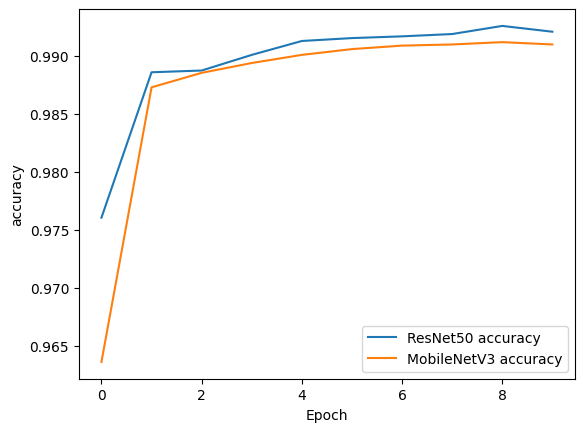

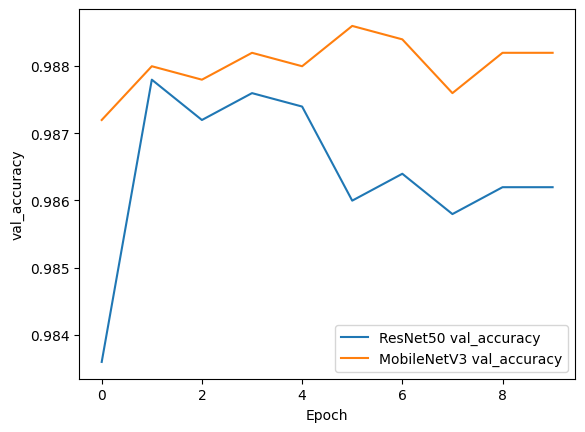

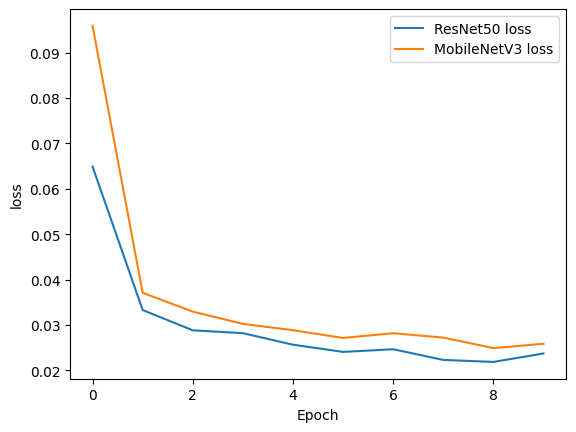

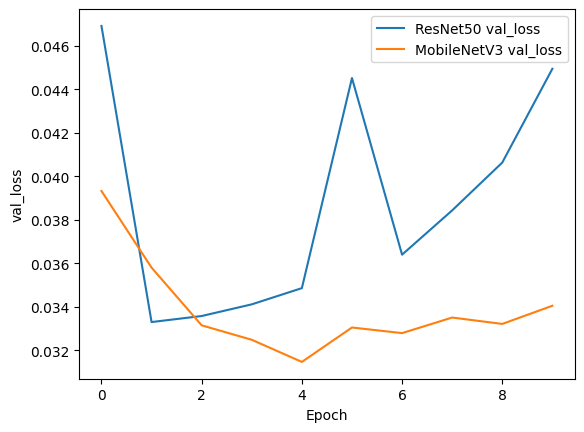

In [69]:
import matplotlib.pyplot as plt

def plot_metric(metric):
    plt.plot(history_resnet.history[metric], label=f'ResNet50 {metric}')
    plt.plot(history_mobilenet.history[metric], label=f'MobileNetV3 {metric}')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.show()

plot_metric('accuracy')
plot_metric('val_accuracy')
plot_metric('loss')
plot_metric('val_loss')

## Classification Report

In [70]:
import numpy as np
from sklearn.metrics import classification_report

y_true = np.concatenate([y for _, y in val_ds], axis=0)

y_pred_resnet = (resnet_model.predict(val_ds) > 0.5).astype(int)
y_pred_mobilenet = (mobilenet_model.predict(val_ds) > 0.5).astype(int)

print("ResNet50 report")
print(classification_report(y_true, y_pred_resnet))

print("MobileNetV3 report")
print(classification_report(y_true, y_pred_mobilenet))

157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step
ResNet50 report
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2475
           1       0.51      0.50      0.51      2524

    accuracy                           0.50      4999
   macro avg       0.50      0.50      0.50      4999
weighted avg       0.50      0.50      0.50      4999

MobileNetV3 report
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2475
           1       0.50      0.50      0.50      2524

    accuracy                           0.50      4999
   macro avg       0.50      0.50      0.50      4999
weighted avg       0.50      0.50      0.50      4999



## Сохранение моделей

In [71]:
resnet_model.save('resnet50_cats_vs_dogs.h5')
mobilenet_model.save('mobilenetv3_cats_vs_dogs.h5')
print("Models saved")

Models saved


MobileNetV3 показала лучший результат, так как обеспечила более высокую точность на валидации и стабильный Loss без признаков переобучения. ResNet50 избыточна для этой задачи: она начинает «зазубривать» тренировочные данные, что ведет к росту ошибки.